<div align="center"><h1>Workforce Analysis - Employee Performance and Well-Being</h1>
    <h3>By: Wiebke Plückhahn, 01/17/2023</h3></div>

This is a follow-up of the "Workforce Analysis - Churn" project. The data preprocessing can be found in the respective notebook. The dataset used in these analyses was saved in the notebook in Google BigQuery and is now imported directly. It is the IBM HR Analytics dataset (available at https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). More in-depth exploratory analyses can also be found in the other notebook (available at https://github.com/WPlueckhahn/Projects/blob/main/Workforce%20Analysis%20-%20Churn.ipynb).

Continuation of the fictious case study...:
In the preliminary discussions, it became clear that the company's HR department is lacking sense of its staff and does not have a clear strategy for their employee management. As they experience breakdowns of performance and sickness absenteeism, the psychometrics of performance, and satisfaction should be further investigated. The goal is to provide insights in reasons for both psychometrics and to answer the question
**What makes employees in this company happy and working well?**

First, the **performance rating** is examined with a **logistic regression** analysis.  
Second, the **job satisfaction** is analyzed fitting a **polynomial (moderated) linear regression**.
Different measures will be recommended.

In [1]:
#Setting up the environment
from factor_analyzer import FactorAnalyzer
from yellowbrick.model_selection import RFECV
import math
import numpy as np
import pandas as pd
import scipy.special
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline
pd.set_option('display.max_columns', 60)

In [2]:
df = pd.read_csv("./churn_formatted.csv")
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Female,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,Married,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human_Resources,Department_Research_Development,Department_Sales,EducationField_Human_Resources,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobRole_Healthcare_Representative,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative
0,45,0,2,364,25,3,2,1,83,3,5,2,0,6502,13035,3,0,22,4,3,0,22,4,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,57,0,1,210,29,3,1,0,56,2,4,4,0,14118,22102,3,0,12,3,3,0,11,3,2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


To answer the project question, multiple regressions will be performed. As some correlations are quite strong and might induce multicollinearity problems a factor analysis will be applied, implementing the factors:
- **Years of Affiliation**: YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager
- **Human Resources**: Department_Human Resources, JobRole_Human Resources
- **Sales**: Department_Sales, JobRole_Sales Executive
- **Job Standing**: JobLevel, MonthlyIncome

Please see the other notebook for further details.

In [3]:
#Factor Analysis
df_fa =df[['JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager',
            'Department_Human_Resources', 'Department_Sales', 'JobRole_Human_Resources', 'JobRole_Sales_Executive']]
fa = FactorAnalyzer(4, rotation='oblimin')
fa.fit(df_fa)
df_loads = pd.DataFrame(np.around(fa.loadings_, 2))
df_loads['var']=['JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager',
                 'Department_Human Resources', 'Department_Sales', 'JobRole_Human Resources', 'JobRole_Sales Executive']
df_loads.set_index('var', inplace=True)
df[['YearsOfAffiliation', 'Human Resources', 'Sales', 'JobStanding']] = fa.fit_transform(df_fa)
df.drop(columns=['JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager',
                 'Department_Human_Resources', 'Department_Sales', 'JobRole_Human_Resources', 'JobRole_Sales_Executive', 'StockOptionLevel'], 
           inplace=True)

The following heatmap shows strength of linear relationships in the data:

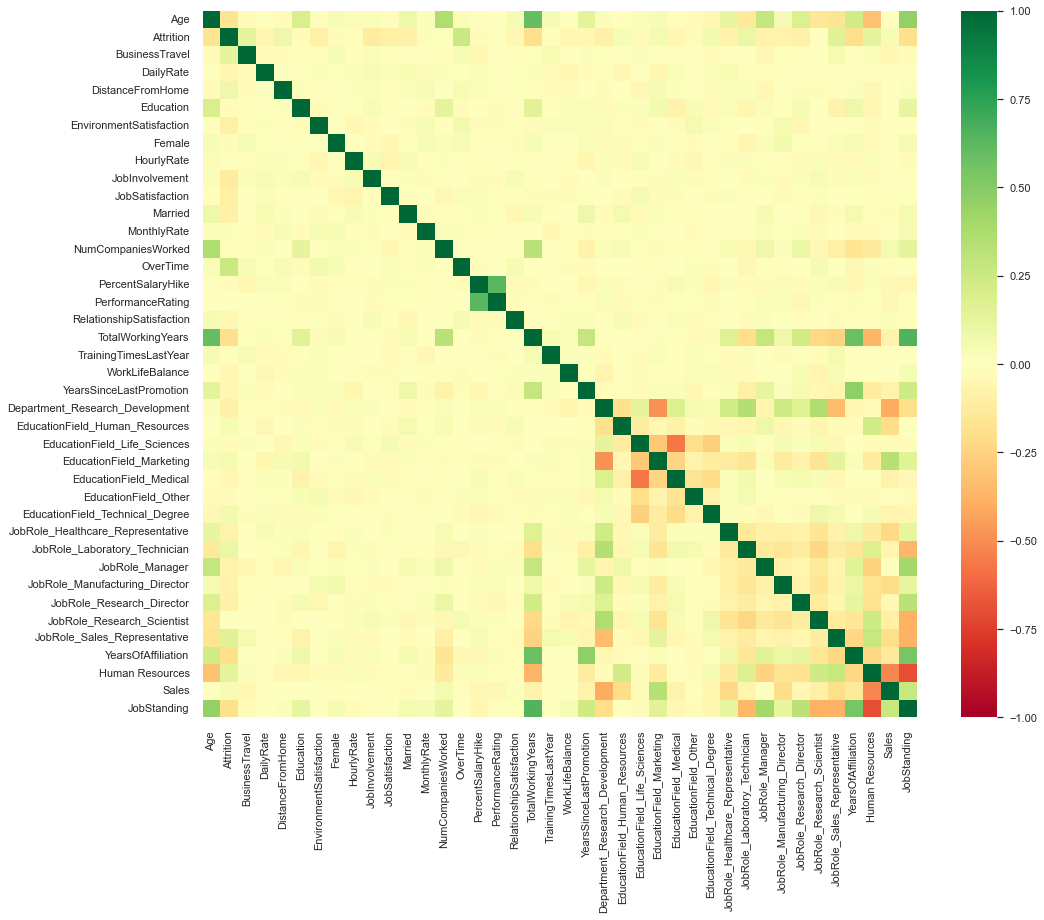

In [4]:
corr= df.corr(method='spearman').round(decimals=2)
plt.figure(figsize=(16,13))
ax=sns.heatmap(corr, xticklabels=True, yticklabels=True, cmap="RdYlGn", vmin=-1, vmax=1)

<h2>Performane</h2>
The performance rating will be examined first - what makes employees perform outstandingly well?
First, the outcome variable will be closer examined.

3    1244
4     226
Name: PerformanceRating, dtype: int64


count    1470.000000
mean        3.153741
std         0.360824
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: PerformanceRating, dtype: float64

<AxesSubplot:xlabel='PerformanceRating', ylabel='count'>

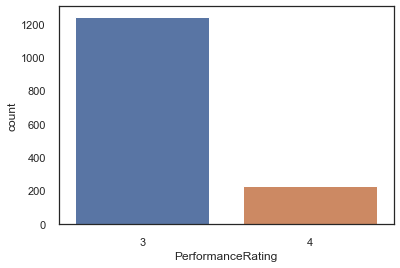

In [5]:
print(df['PerformanceRating'].value_counts())
display(df['PerformanceRating'].describe())
sns.countplot(x='PerformanceRating', data=df)

In the data, all employees are rated with 3 (excellent) or 4 (outstanding). This makes performance rating a binary variable and the scale points will be adjusted to 0 = excellent and 1 = outstanding. A logisitc regression will then be performed to unravel important features of outstanding employees.

In [6]:
df['PerformanceRating'].replace({3:0, 4:1}, inplace=True)

All assumptions of logistic regression were checked in the first notebook. Only linearity of relationships between peformance rating and all other variables needs to be assessed.

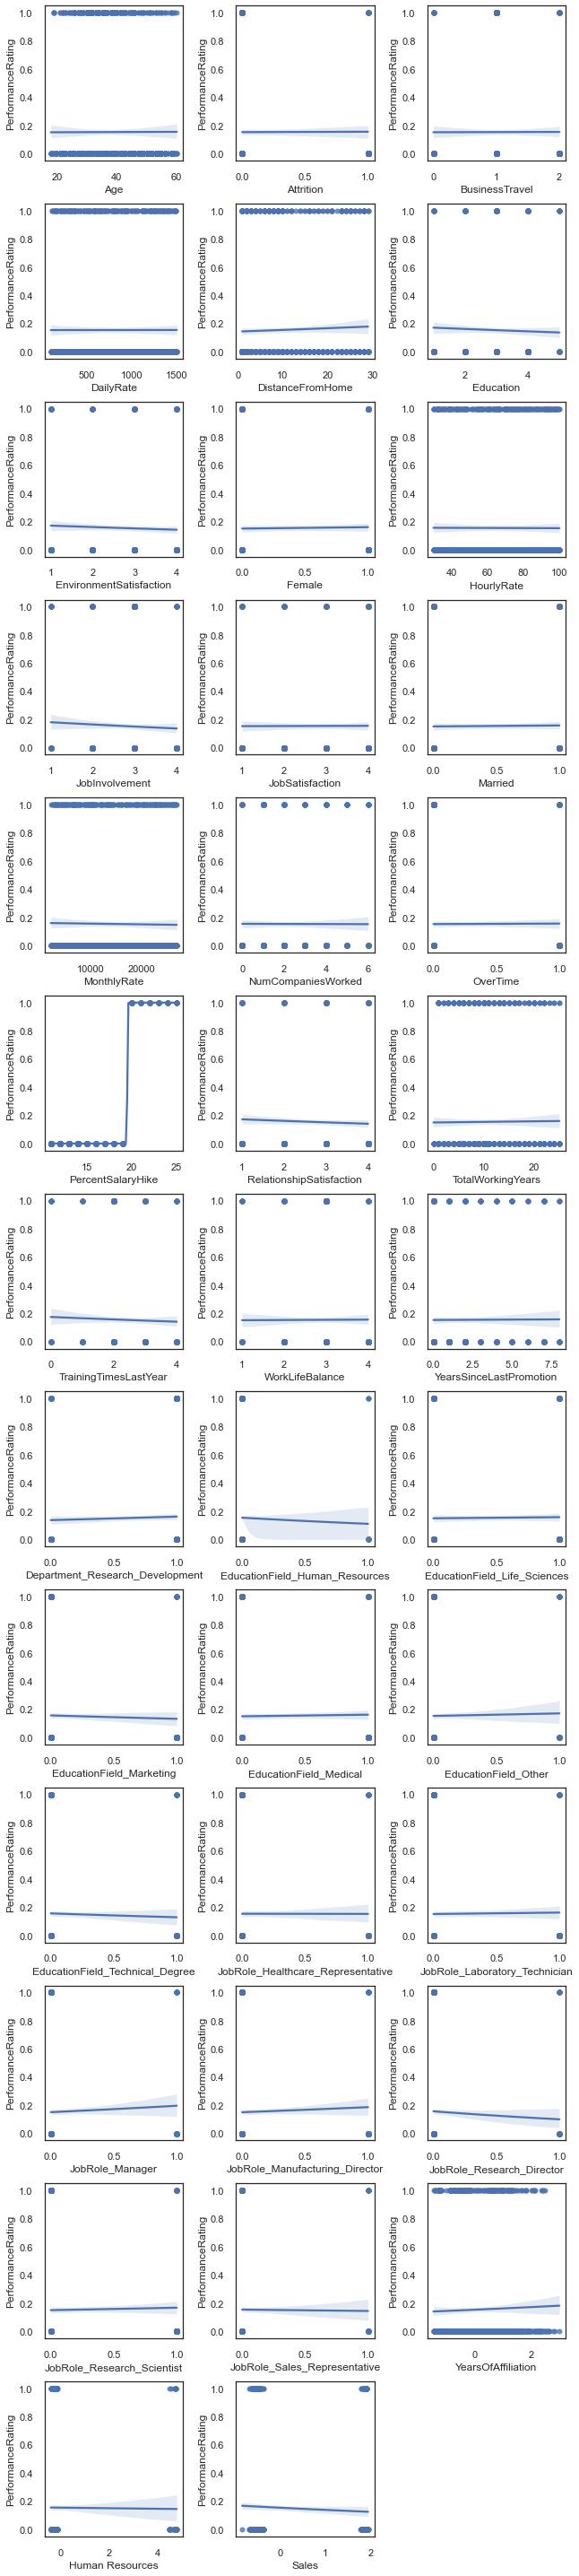

In [7]:
cols=df.columns.tolist()
cols.remove('PerformanceRating')
no_cols=len(cols)
fig_row=math.ceil(no_cols/3)

fig=plt.figure()
fig.set_size_inches(9,40)

for i in range(0, no_cols-1):
    ax=fig.add_subplot(fig_row, 3, i+1)
    sns.regplot(x= df[cols[i]].astype(float), y= df['PerformanceRating'].astype(int), logistic= True, ax=ax)
fig.tight_layout()
plt.show()

The relationships seem to be quite weak. Only the curve of PercentSalaryHike appears to be sigmoid showing (almost) perfect separation. As the main goal is inference, no train-test-split will be conducted.

In [8]:
#Data definition
X = df.loc[:, df.columns != 'PerformanceRating']
y = df.loc[:, df.columns == 'PerformanceRating']
columns=X.columns.tolist()

#standardization
scaler=StandardScaler().fit(X)
stand_X = scaler.transform(X)

As only the features relevant to answering the research question should stay in the final model, the number of relevant features in the data will be determined next.

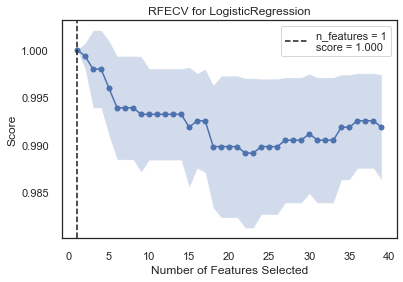

<AxesSubplot:title={'center':'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [9]:
# Determine the optimal number of features by RFECV visualizer
logreg = LogisticRegression()
visualizer = RFECV(logreg)

visualizer.fit(stand_X, y)
visualizer.show()

The recursive feature elimination results in optimally including only 1 feature in the final model. The specific feature will now be determined.

In [10]:
#Fit the RFE model with 1 feature
logreg = LogisticRegression()
rfe = RFE(logreg,
    n_features_to_select=1,
    step=40)
rfe.fit(stand_X, y.values.ravel())

#Feature selection
features = pd.DataFrame()
features['col']=X.columns.tolist()
features['include']=rfe.support_
index=features.loc[features['include']==True, ['col']]['col'].tolist()
print('The features for modeling the logistic regression are:', index)
stand_X=pd.DataFrame(stand_X, columns=columns)
X_final=stand_X[index]

The features for modeling the logistic regression are: ['PercentSalaryHike']


Percent salary hike is the only predictor of performance rating in the data. As no tests for significance are included in the scikit-learn library, the final model will be tested with statsmodels.

In [11]:
#adding intercept
X_final = sm.add_constant(X_final)

#performing lr
logit_model=sm.Logit(y, X_final)
result=logit_model.fit(method='bfgs')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
                           Results: Logit
Model:                Logit             Pseudo R-squared: 1.000      
Dependent Variable:   PerformanceRating AIC:              4.0278     
Date:                 2023-01-18 11:24  BIC:              14.6138    
No. Observations:     1470              Log-Likelihood:   -0.013901  
Df Model:             1                 LL-Null:          -630.84    
Df Residuals:         1468              LLR p-value:      2.4308e-276
Converged:            1.0000            Scale:            1.0000     
Method:               MLE                                            
---------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
---------------------------------------------------------------------
const           

The regplot already indicated that relationships of all features with the performance rating are not very strong. In fact, percent salary hike does not significantly predict performance rating. But why is this feature determined as important? As the data is cross-sectional, correlation must not be confused with causation. Finally, when inspecting the correlation, percent salary hike is highly correlated with the performance rating. But what does that mean?

In [12]:
df[['PercentSalaryHike', 'PerformanceRating']].corr()

,PercentSalaryHike,PerformanceRating
PercentSalaryHike,1.00000,0.77355
PerformanceRating,0.77355,1.00000


The overall picture of the data rather reveals the following: employees who are performaning outstandingly well often get a pay rise.
Deriving the measure that badly performing employees should get a pay raise would be fatal.
Based on the current data, it is not possible to draw any conclusions as to what makes the company's employees perform particularly well.

<h2>Well-Being</h2>
<h3>Job Satiscation</h3>
What makes employees happy with their job and are there any intercations in the data?
Again, the outcome will first be examined.

4    459
3    442
1    289
2    280
Name: JobSatisfaction, dtype: int64


count    1470.000000
mean        2.728571
std         1.102846
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: JobSatisfaction, dtype: float64

<AxesSubplot:xlabel='JobSatisfaction', ylabel='count'>

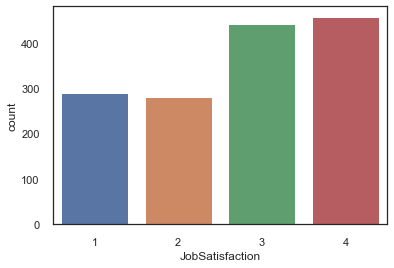

In [13]:
print(df['JobSatisfaction'].value_counts())
display(df['JobSatisfaction'].describe())
sns.countplot(x='JobSatisfaction', data=df)

Job Satisfaction is quite evenly distributed across employees, ranging from 1- low to 4 - very high. As linear relationships matter for linear regression, relationships of all features with job satisfaction are plotted below.

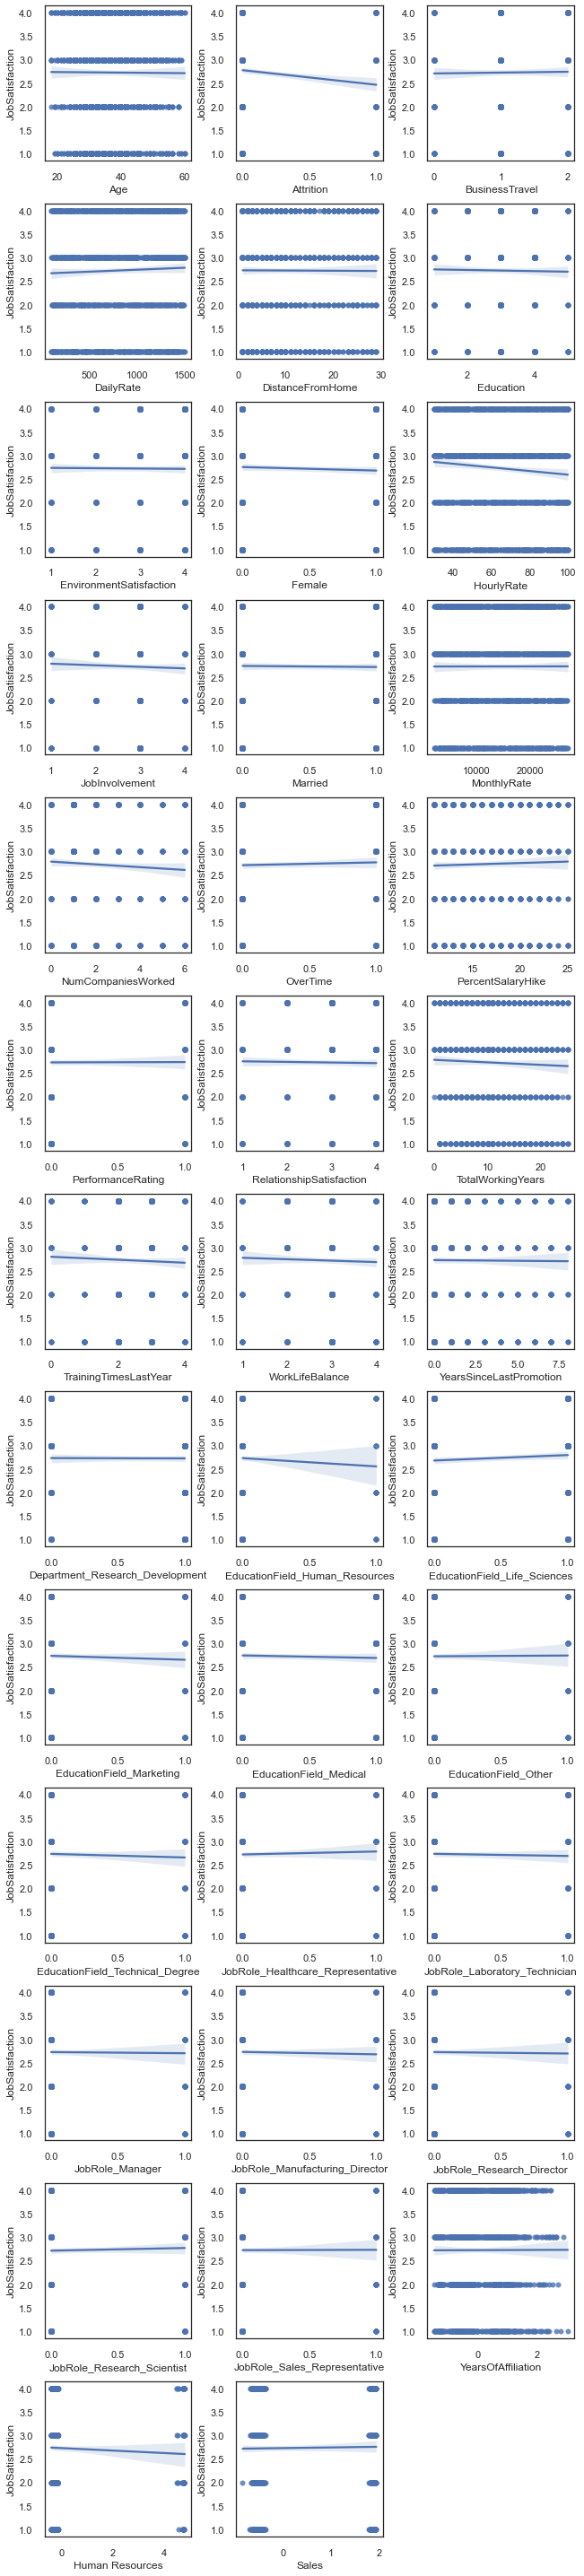

In [14]:
cols=df.columns.tolist()
cols.remove('JobSatisfaction')
no_cols=len(cols)
fig_row=math.ceil(no_cols/3)

fig=plt.figure()
fig.set_size_inches(9,40)

for i in range(0, no_cols-1):
    ax=fig.add_subplot(fig_row, 3, i+1)
    sns.regplot(x= df[cols[i]].astype(float), y= df['JobSatisfaction'].astype(int), ax=ax)
fig.tight_layout()
plt.show()

The linear relationships appear to be a little bit stronger than in the previous model. As this analysis will include interaction terms, the transformation will be applied next.
Below, the polynomial matrix holding the interactions of all variables will be computed.

In [15]:
#Data definition
X = df.loc[:, df.columns != 'JobSatisfaction']
y = df.loc[:, df.columns == 'JobSatisfaction']
columns=X.columns.tolist()

#standardization
scaler=StandardScaler().fit(X)
stand_X = scaler.transform(X)

#generate matrix for interaction
poly = PolynomialFeatures(degree=2, interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X)
#X_poly = pd.DataFrame(X_poly)
print('The transformed data should be', len(columns)+scipy.special.binom(len(columns), 2), 'features long and is',
     X_poly.shape[1], 'features long.')

#Generating feature labels of the polynomial matrix
polycols = X.columns.tolist()

col=0
for col in range(0, len(columns)-1):
    for i in range(col, len(columns)-1):
        polycols.append(columns[col]+'*'+columns[i])
    col=col+1
    
print(len(polycols), 'feature labels were generated.')

The transformed data should be 780.0 features long and is 780 features long.
780 feature labels were generated.


The transformed matrix holds each primary variable from the original dataframe (except for job satisfaction as this is the outcome). Also, it contains the squares of all features to test for curvilinear effects. Lastly, it includes all interactions of all features that were derived by multiplying the features with one another.
These 780 variables are now subjected to a multiple (linear) regression. Of course, a lot of features will lack significance in the first model and will be trimmed before displaying the (very long) results table.

In [16]:
X_poly = pd.DataFrame(X_poly, columns=polycols)

#adding an intercept
X_poly = sm.add_constant(X_poly)

#performing lr
lr = sm.OLS(y, X_poly)
result=lr.fit()





#trimming the model - excluding irrelevant features
p_lr=pd.DataFrame(result.summary2().tables[1]['P>|t|'])
cols=p_lr[p_lr['P>|t|']<.05].index.tolist() #this holds the significant features

#main effects must be kept in the model if significance occurs. Therefore, the main effects will be added back
finalcols = list(cols)

for i in range(0, len(cols)-1):
    x = cols[i].split("*")
    finalcols.insert(0, x[0])
    finalcols.insert(0, x[1])
    
#removing duplicates
finalcols = list(dict.fromkeys(finalcols))
finalcols.insert(0, 'const')

X_poly=X_poly[finalcols]

#performing lr
lr = sm.OLS(y, X_poly)
result=lr.fit()





#some features now lack significance - repeating the steps above
#trimming the model - excluding irrelevant features
p_lr=pd.DataFrame(result.summary2().tables[1]['P>|t|'])
cols=p_lr[p_lr['P>|t|']<.05].index.tolist() #this holds the significant features

#main effects must be kept in the model if significance occurs. Therefore, the main effects will be added back
finalcols2 = list(cols)

for i in range(7, len(cols)-1):
    x = cols[i].split("*")
    finalcols2.insert(0, x[0])
    finalcols2.insert(0, x[1])
    
#removing duplicates
finalcols2.insert(0, 'const')
finalcols2 = list(dict.fromkeys(finalcols2))

X_poly=X_poly[finalcols2]

#performing lr
lr = sm.OLS(y, X_poly)
result=lr.fit()






#still, some features lack significance - repeating the steps above
#trimming the model - excluding irrelevant features
p_lr=pd.DataFrame(result.summary2().tables[1]['P>|t|'])
cols=p_lr[p_lr['P>|t|']<.05].index.tolist() #this holds the significant features

#main effects must be kept in the model if significance occurs. Therefore, the main effects will be added back
finalcols3 = list(cols)

for i in range(8, len(cols)-1):
    x = cols[i].split("*")
    finalcols3.insert(0, x[0])
    finalcols3.insert(0, x[1])
    
#removing duplicates
finalcols3.insert(0, 'const')
finalcols3 = list(dict.fromkeys(finalcols3))

X_poly=X_poly[finalcols3]

#performing lr
lr = sm.OLS(y, X_poly)
result=lr.fit()
print(result.summary2())
print('Goldfeld-Quandt test for heterosckedasticity:',sm.stats.diagnostic.het_goldfeldquandt(result.resid, result.model.exog))

                            Results: Ordinary least squares
Model:                     OLS                     Adj. R-squared:            0.030    
Dependent Variable:        JobSatisfaction         AIC:                       4428.8878
Date:                      2023-01-18 11:24        BIC:                       4508.2830
No. Observations:          1470                    Log-Likelihood:            -2199.4  
Df Model:                  14                      F-statistic:               4.300    
Df Residuals:              1455                    Prob (F-statistic):        1.60e-07 
R-squared:                 0.040                   Scale:                     1.1792   
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
const                                    2.4353   0.3036  8.

Multicollinearity is a problem inherent in (almost) all regression models featuring interactions as the interaction term very likely is highly correlated with the main variables. In general, linear models are quite robust to violations of assumptions, therefore no further transformations will be applied.  
The final model contains the following significant primary predictors:
- **Positive**:
    - **Over time** (but it depends on **PercentSalaryHike** due to the interaction)
    - **Daily rate** (but it depends on **RelationshipSatisfaction** due to the interaction)
    - **Age** (but it depends on **WorkLifeBalance** due to the interaction)
    - **Performance rating** (but it depends on **TrainingTimesLastYear** due to the interaction)
    - **Years since last promotion**
- **Negative**:
    - **Hourly rate**
    - **Attrition**
    
The four significant interactions will be plotted next:

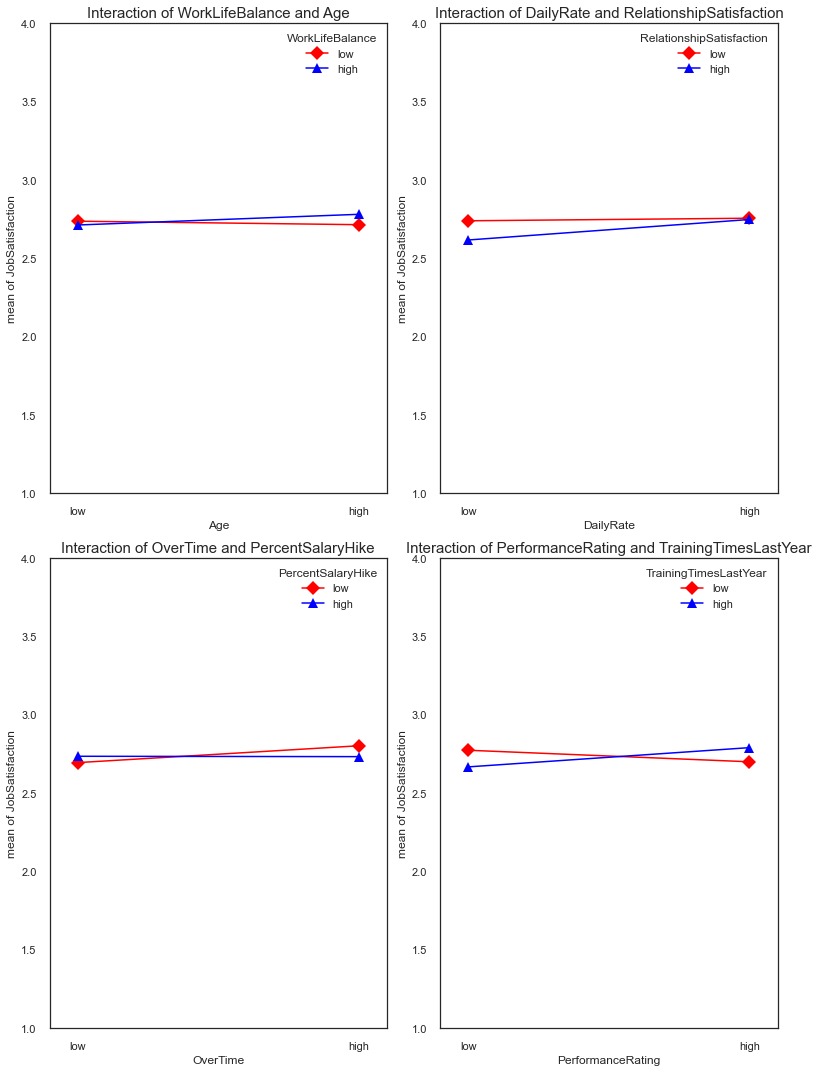

In [17]:
jobsat = df['JobSatisfaction']

#Age
Age = df['Age']
m = Age.median()
Age.mask(Age <= m, 0, inplace=True)
Age.mask(Age > m, 1, inplace=True)

#Work Life Balance
WorkLifeBalance = df['WorkLifeBalance']
m = WorkLifeBalance.median()
WorkLifeBalance.mask(WorkLifeBalance <= m, 0, inplace=True)
WorkLifeBalance.mask(WorkLifeBalance > m, 1, inplace=True)

#Daily Rate
DailyRate = df['DailyRate']
m = DailyRate.median()
DailyRate.mask(DailyRate <= m, 0, inplace=True)
DailyRate.mask(DailyRate > m, 1, inplace=True)

#RelationshipSatisfaction
RelationshipSatisfaction = df['RelationshipSatisfaction']
m = RelationshipSatisfaction.median()
RelationshipSatisfaction.mask(RelationshipSatisfaction <= m, 0, inplace=True)
RelationshipSatisfaction.mask(RelationshipSatisfaction > m, 1, inplace=True)

#OverTime
OverTime = df['OverTime']
m = OverTime.median()
OverTime.mask(OverTime <= m, 0, inplace=True)
OverTime.mask(OverTime > m, 1, inplace=True)

#PercentSalaryHike
PercentSalaryHike = df['PercentSalaryHike']
m = PercentSalaryHike.median()
PercentSalaryHike.mask(PercentSalaryHike <= m, 0, inplace=True)
PercentSalaryHike.mask(PercentSalaryHike > m, 1, inplace=True)

#PerformanceRating
PerformanceRating = df['PerformanceRating']
m = PerformanceRating.median()
PerformanceRating.mask(PerformanceRating <= m, 0, inplace=True)
PerformanceRating.mask(PerformanceRating > m, 1, inplace=True)

#TrainingTimesLastYear
TrainingTimesLastYear = df['TrainingTimesLastYear']
m = TrainingTimesLastYear.median()
TrainingTimesLastYear.mask(TrainingTimesLastYear <= m, 0, inplace=True)
TrainingTimesLastYear.mask(TrainingTimesLastYear > m, 1, inplace=True)



#Plottting
fig = plt.figure()
fig.set_size_inches(11, 15)

#Age*WorkLifeBalance
ax0 = fig.add_subplot(221)
interaction_plot(
    x=Age,
    trace=WorkLifeBalance,
    response=jobsat,
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax0)
ax0.set_ylim(1,4)
plt.xticks([0,1], labels=['low', 'high'])
plt.legend(['low', 'high'], title='WorkLifeBalance')
plt.title('Interaction of WorkLifeBalance and Age', fontsize=15)

#DailyRate*RelationshipSatisfaction
ax1 = fig.add_subplot(222)
interaction_plot(
    x=DailyRate,
    trace=RelationshipSatisfaction,
    response=jobsat,
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax1)
ax1.set_ylim(1,4)
plt.xticks([0,1], labels=['low', 'high'])
plt.legend(['low', 'high'], title='RelationshipSatisfaction')
plt.title('Interaction of DailyRate and RelationshipSatisfaction', fontsize=15)

#OverTime*PercentSalaryHike
ax2 = fig.add_subplot(223)
interaction_plot(
    x=OverTime,
    trace=PercentSalaryHike,
    response=jobsat,
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax2)
ax2.set_ylim(1,4)
plt.xticks([0,1], labels=['low', 'high'])
plt.legend(['low', 'high'], title='PercentSalaryHike')
plt.title('Interaction of OverTime and PercentSalaryHike', fontsize=15)

#PerformanceRating*TrainingTimesLastYear
ax3 = fig.add_subplot(224)
interaction_plot(
    x=PerformanceRating,
    trace=TrainingTimesLastYear,
    response=jobsat,
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax3)
ax3.set_ylim(1,4)
plt.xticks([0,1], labels=['low', 'high'])
plt.legend(['low', 'high'], title='TrainingTimesLastYear')
plt.title('Interaction of PerformanceRating and TrainingTimesLastYear', fontsize=15)

plt.tight_layout()
plt.show()

The results show the following picture: 

That attrition is negatively related to job satisfaction is pretty straightforward.
What is surprising are the findings that a higher hourly rate reduces job satisfaction, although it is not the hourly rate that could be decisive here, but possibly the working conditions in jobs that are better paid. Another surprising finding is that a longer time since the last promotion is positively associated with job satisfaction. It is possible that settling into the new job after a promotion could initially reduce job satisfaction, so that promoted employees should be given **good onboarding**.

Also, some interaction effects reached significance. Older employees tend to have a higher job satisfaction, however, only if they have a good work life balance. **Work life balance** therefore is a topic the company should invest in.  
A second significant interaction was that of performance rating and training times last year. A good performance rating only predicted a higher job satisfaction in employees that received more trainings over the past year. From this, it can be deduced that the performance of particularly good employees should be rewarded by providing them with **further support and training**.  
The other two interactions are not really suitable for deriving measures, but are still interesting. The a higher daily rate only increased job satisfaction in individuals that were satisfied in their relationship. However, this factor external to the company cannot be manipulated. Furthermore, working over time only increased job satisfaction in employees that got no or only a small pay rise. This finding is very interesting and also might be due to ommitted variables.

<h2>Conlusion</h2>

Regarding performance, no recommendations can be made from the present data. In order to develop valuable talent management programs, further data should be acquired and analyzed, potentially considering team structures and nesting of employees and leaders, as well as examining performance via self- and external assessment.

With regard to job satisfaction, a fairly differentiated picture was obtained. Three measures are derived from the data and the following recommendations can be made to foster job satisfaction in the work force:
- First, employees that are promoted should run through a good **onboarding** process to enable a quick settling into the new job. Ideally, the onboarding program will be derived from data evidence. An additional data project will be valuable here.
- Second, outstandingly performing employees should be provided with **further training** to further support them in their careers. Candidate selection could be a component of a **talent management** program. The development and implementation of such a program also should be data-driven. The implementation of another data project will provide good value. Potentially, the onboarding and talent management projects are compatible with each other and can be integrated into one overarching project. It would also be useful to address further question related to employee performance in this project.
- Third, the company should make sure that the **work life balance** of its employees is right. For example, measures should be established such as switching off the work phone after work and on weekends, and to decrease over time and working after hours. The managers are the key to establishing the norms within their teams. Training should start with them.